In [1]:
# # Colab setup

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [1]:
# Import libraries

import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from dolfin import *
from dlroms import *
from dlroms.dnns import *

from IPython.display import clear_output as clc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Domain and mesh definition

mesh_H = fe.unitsquaremesh(100, 100) # fine mesh
V_H = fe.space(mesh_H, 'CG', 1)
Nh_H = V_H.dim()

mesh_C = fe.unitsquaremesh(50, 50) # coarse mesh
V_C = fe.space(mesh_C, 'CG', 1)
Nh_C = V_C.dim()

clc()

In [4]:
# Load snapshots

N_snapshots_H = 300

path_train_H = os.path.join('snapshots', 'snapshots_train_H_' + str(N_snapshots_H) + '.npz')
data_train_H = np.load(path_train_H)

N_train_H = data_train_H['mu'].shape[0]
mu_train_H, u_train_H = data_train_H['mu'].astype(np.float32), data_train_H['u'].astype(np.float32)
mu_train_H, u_train_H = torch.tensor(mu_train_H).to(device), torch.tensor(u_train_H).to(device)

N_snapshots_C = 4800

path_train_C = os.path.join('snapshots', 'snapshots_train_C_' + str(N_snapshots_C) + '.npz')
data_train_C = np.load(path_train_C)

N_train_C = data_train_C['mu'].shape[0]
mu_train_C, u_train_C = data_train_C['mu'].astype(np.float32), data_train_C['u'].astype(np.float32)
mu_train_C, u_train_C = torch.tensor(mu_train_C).to(device), torch.tensor(u_train_C).to(device)

path_test = os.path.join('snapshots', 'snapshots_test.npz')
data_test = np.load(path_test)

N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [ ]:
# Traning architecture

m = 16
k = 4

psi_prime = Dense(Nh_C, 4, activation=None)

psi = Dense(4, 100 * m) + \
		Reshape(4 * m, 5, 5) + \
		Deconv2D(7, (4 * m, 2 * m), 1) + \
		Deconv2D(4, (2 * m, m), 2) + \
		Deconv2D(5, (m, 1), 2, activation=None) + \
		Reshape(-1)

phi = Dense(4, 50 * k) + \
		Dense(50 * k, 50 * k) + \
		Dense(50 * k, 4, activation=None)

chi = Local(V_C, V_H, support=0.1, activation=None)

print("Trainable parameters:")
print("  Encoder:", psi_prime.dof())
print("  Decoder:", psi.dof())
print("  Dense NN:", phi.dof())
print("  Mesh-informed layer:", chi.dof())

In [7]:
# Train the autoencoder on the low-fidelity dataset

autoencoder = DFNN(psi_prime, psi) # encoder + decoder
autoencoder.He()

if torch.cuda.is_available():
	autoencoder.cuda()

autoencoder.train(u_train_C, u_train_C, ntrain=N_train_C, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	3.39e-02	nan.

>> ETA: 2.59s.

Training complete. Elapsed time: 8 minutes 38.71 seconds.


In [8]:
# Use the trained encoder to generate the reduced-order version of the low-fidelity dataset

psi_prime.eval()

with torch.no_grad():
	u_train_C_ro = psi_prime(u_train_C)

In [9]:
# Use the reduced-order low-fidelity dataset to train the dense NN mapping the parameters to the reduced-order low-fidelity solution

dense = DFNN(phi)
dense.He()

if torch.cuda.is_available():
	dense.cuda()

dense.train(mu_train_C, u_train_C_ro, ntrain=N_train_C, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	5.10e-02	nan.

>> ETA: 0.28s.

Training complete. Elapsed time: 56.28 seconds.


In [10]:
# Train the multi-fidelity model

phi.freeze() # freeze the dense NN
psi.freeze() # freeze the decoder

chi.He()

model = DFNN(phi, psi, chi)

if torch.cuda.is_available():
	model.cuda()

model.train(mu_train_H, u_train_H, ntrain=N_train_H, epochs=40, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 40:	8.80e-02	nan.

>> ETA: 0.65s.

Training complete. Elapsed time: 26.13 seconds.


In [11]:
# Use the final model to predict the high-fidelity solution

model.eval()

with torch.no_grad():
	u_train_H_pred = model(mu_train_H)

error_train = mre(euclidean)(u_train_H, u_train_H_pred)
print(f"Relative training error: {100 * torch.mean(error_train):.2f}%")

In [ ]:
# Apply the model to the test set

with torch.no_grad():
	u_test_pred = model(mu_test)

error_test = mre(euclidean)(u_test, u_test_pred)
print(f"Relative test error: {100 * torch.mean(error_test):.2f}%")

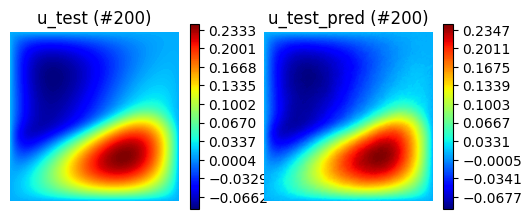

In [15]:
# Plot some results

index = 200

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
fe.plot(u_test[index, :], V_H, colorbar=True)
plt.title('u_test (#' + str(index) + ')')
plt.subplot(1, 2, 2)
fe.plot(u_test_pred[index, :], V_H, colorbar=True)
plt.title('u_test_pred (#' + str(index) + ')')
plt.show()

In [17]:
# Save encoder, decoder, dense NN, and mesh-informed layer

torch.save(psi_prime.state_dict(), os.path.join('checkpoints', 'psi_prime_' + str(N_snapshots_C) + '_' + str(N_snapshots_H) + '.pth'))
torch.save(psi.state_dict(), os.path.join('checkpoints', 'psi_' + str(N_snapshots_C) + '_' + str(N_snapshots_H) + '.pth'))
torch.save(phi.state_dict(), os.path.join('checkpoints', 'phi_' + str(N_snapshots_C) + '_' + str(N_snapshots_H) + '.pth'))
torch.save(chi.state_dict(), os.path.join('checkpoints', 'chi_' + str(N_snapshots_C) + '_' + str(N_snapshots_H) + '.pth'))